In [124]:
options = ["Naive", "Informed", "Weighted"]
SENSOR_AGGREGATION = options[1]

agg_colors = {"Naive": 15, "Informed": 10, "Weighted": 5} # tab20b

aggregation_color_skips = agg_colors[SENSOR_AGGREGATION]

In [125]:
import os
import zipfile
import pickle
import json
from typing import Dict, List
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from matplotlib.ticker import FormatStrFormatter

In [126]:
for filename in os.listdir("./"):
    if filename.lower().endswith('.pdf'):
        file_path = os.path.join("./", filename)
        os.remove(file_path)
    if filename.lower().endswith('.zip'):
        file_path = os.path.join("./", filename)
        os.remove(file_path)

In [127]:
def init_default_params():
    plt.style.use('default') # reset settings
    sns.set_style("whitegrid") # sns gridstyle plot
    # font sizes
    plt.rcParams.update({"font.size": 14})
    plt.rcParams.update({"axes.titlesize": 16})

    # create own colormap for 5 different color shades
    # Extract the original tab20b colors
    tab20b = plt.get_cmap('tab20b')
    original_colors = tab20b(np.linspace(0, 1, 20))

    # Function to interpolate colors
    def interpolate_colors(colors, num_colors):
        interpolated_colors = []
        for i in range(0, len(colors), 4):
            group = colors[i:i+4]
            for j in range(num_colors):
                t = j / (num_colors - 1)
                interpolated_color = (
                    (1 - t) * group[0] + t * group[-1]
                )
                interpolated_colors.append(interpolated_color)
        return interpolated_colors

    # Create a new colormap with 5 shades per color
    new_colors = interpolate_colors(original_colors, 5)
    custom_cmap = ListedColormap(new_colors)

    # color cycling
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_cmap.colors)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = itertools.cycle(prop_cycle.by_key()['color'])
    # marker cycling
    markers = itertools.cycle(('s', 'd', '^', 'v'))
    return markers, colors

## Attack Windows

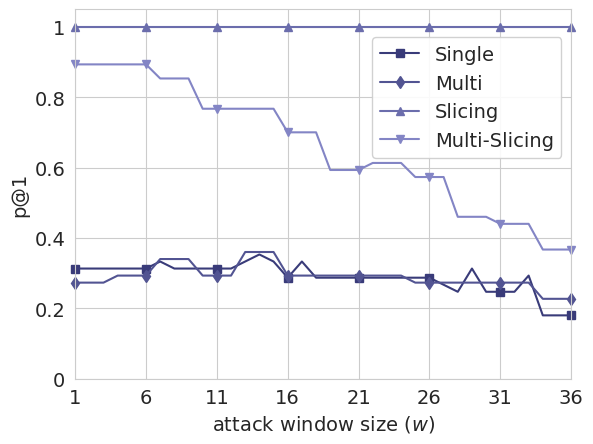

In [128]:
markers, colors = init_default_params()
idxs = [0,1,2,3]
markers = itertools.cycle([list(itertools.islice(markers, 4))[idx] for idx in idxs]) # correct marker order
color_skips = [None] * 0 # skip to correct color
[next(colors) for skip in color_skips]
colors = [next(colors) for idx in idxs]
colors = itertools.cycle([colors[idx] for idx in idxs]) # correct color order

# attack window plot
def create_attack_dict():
    combined_dict = {}

    file_list = [
        ('./window_results_single.json', 'Single'),
        ('./window_results_multi.json', 'Multi'),
        ('./window_results_slicing.json', 'Slicing'),
        ('./window_results_multi_slicing.json', 'Multi-Slicing')
    ]

    for path, attack_name in file_list:
        with open(path) as f:
            json_dict = json.load(f)
        combined_dict[attack_name] = json_dict.pop('1')
    return combined_dict

attack_dict = create_attack_dict()

plt.ylabel('p@1')
plt.xlabel('attack window size ($w$)')
plt.xticks(range(0, 37, 5))  # Start at 0, end at 36, step by 5

for attack_name in attack_dict.keys():
    results = attack_dict[attack_name]
    x, y = zip(*sorted(results.items(), key=lambda item: int(item[0])))
    if attack_name.startswith('Multi'):
        x_long = list(range(1, 37))  # x values from 1 to 36
        y_long = []
        for i in range(len(y)):
            y_long.extend([y[i]] * 3)  # Repeat each y value 3 times
        x, y = x_long, y_long  # Update x and y
        x = [str(i) for i in x]
    plt.plot(x, y, label=attack_name, color=next(colors), marker=next(markers), markevery=5, clip_on=False)

ax = plt.gca()
ax.set_xlim(left=0, right=35)
ax.set_ylim(bottom=0, top=1.05)

#plt.locator_params(axis="x", nbins=8)
#plt.locator_params(axis="y", nbins=8)

ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.legend(loc="upper right", bbox_to_anchor=(1.0, 0.95), framealpha=0.9)
plt.savefig("windows_evaluation.pdf", format="pdf")

## Attack Results

In [129]:
values_dict = {
    "Naive": {
        "Single-DTW": {
            "p@1": [("WESAD", 0.353, "w=14", "max@k=12"), ("CGAN$_{15}$", 0.267, "w=4", "max@k=14"), ("DGAN$_{15}$", 0.179, "w=5", "max@k=15"), ("CGAN$_{10000}$", 0.0, "w=20", "max@k=9963"), ("DGAN$_{10000}$", 0.0, "w=23", "max@k=9893")],
            "p@3": [("WESAD", 0.58),                      ("CGAN$_{15}$", 0.437),                    ("DGAN$_{15}$", 0.313),                    ("CGAN$_{10000}$", 0.0),                       ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 0.76),                      ("CGAN$_{15}$", 0.648),                    ("DGAN$_{15}$", 0.446),                    ("CGAN$_{10000}$", 0.0),                       ("DGAN$_{10000}$", 0.0)]
        },
        "Multi-DTW": {
            "p@1": [("WESAD", 0.36, "w=5", "max@k=12"), ("CGAN$_{15}$", 0.277, "w=5", "max@k=13"), ("DGAN$_{15}$", 0.154, "w=4", "max@k=15"), ("CGAN$_{10000}$", 0.0, "w=1", "max@k=9820"), ("DGAN$_{10000}$", 0.0, "w=4", "max@k=9883")],
            "p@3": [("WESAD", 0.587),                   ("CGAN$_{15}$", 0.485),                    ("DGAN$_{15}$", 0.246),                    ("CGAN$_{10000}$", 0.0),                      ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 0.76),                    ("CGAN$_{15}$", 0.523),                    ("DGAN$_{15}$", 0.379),                    ("CGAN$_{10000}$", 0.0),                      ("DGAN$_{10000}$", 0.0)]
        },
        "Slicing-DTW": {
            "p@1": [("WESAD", 1.0, "w=1", "max@k=1"), ("CGAN$_{15}$", 1.0, "w=1", "max@k=1"), ("DGAN$_{15}$", 1.0, "w=1", "max@k=1"), ("CGAN$_{10000}$", 1.0, "w=34", "max@k=1"), ("DGAN$_{10000}$", 1.0, "w=32", "max@k=1")],
            "p@3": [("WESAD", 1.0),                   ("CGAN$_{15}$", 1.0),                   ("DGAN$_{15}$", 1.0),                   ("CGAN$_{10000}$", 1.0),                       ("DGAN$_{10000}$", 1.0)],
            "p@5": [("WESAD", 1.0),                   ("CGAN$_{15}$", 1.0),                   ("DGAN$_{15}$", 1.0),                   ("CGAN$_{10000}$", 1.0),                       ("DGAN$_{10000}$", 1.0)]
        },
        "Multi-Slicing-DTW": {
            "p@1": [("WESAD", 0.893, "w=1", "max@k=3"), ("CGAN$_{15}$", 0.296, "w=7", "max@k=15"), ("DGAN$_{15}$", 0.343, "w=6", "max@k=15"), ("CGAN$_{10000}$", 0.0, "w=10", "max@k=9765"),     ("DGAN$_{10000}$", 0.0, "w=5", "max@k=9995")],
            "p@3": [("WESAD", 1.0),                     ("CGAN$_{15}$", 0.429),                    ("DGAN$_{15}$", 0.451),                    ("CGAN$_{10000}$", 0.003),                         ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 1.0),                     ("CGAN$_{15}$", 0.592),                    ("DGAN$_{15}$", 0.559),                    ("CGAN$_{10000}$", 0.003),                         ("DGAN$_{10000}$", 0.003)]
        },
    },

    "Informed": {
        "Single-DTW": {
            "p@1": [("WESAD", 1.0, "w=14", "max@k=1", "bvp"), ("CGAN$_{15}$", 0.3, "w=4", "max@k=13", "bvp+acc"), ("DGAN$_{15}$", 0.175, "w=5", "max@k=14", "bvp"), ("CGAN$_{10000}$", 0.0, "w=20", "max@k=7247", "bvp+acc"), ("DGAN$_{10000}$", 0.0, "w=23", "max@k=7380", "bvp+temp+acc")],
            "p@3": [("WESAD", 1.0),                           ("CGAN$_{15}$", 0.433),                             ("DGAN$_{15}$", 0.329),                           ("CGAN$_{10000}$", 0.0),                               ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 1.0),                           ("CGAN$_{15}$", 0.567),                             ("DGAN$_{15}$", 0.508),                           ("CGAN$_{10000}$", 0.0),                               ("DGAN$_{10000}$", 0.0)]
        },
        "Multi-DTW": {
            "p@1": [("WESAD", 1.0, "w=5", "max@k=1", "bvp"), ("CGAN$_{15}$", 0.3, "w=5", "max@k=12", "bvp+acc"), ("DGAN$_{15}$", 0.146, "w=4", "max@k=15", "bvp+acc"), ("CGAN$_{10000}$", 0.0, "w=1", "max@k=6903", "bvp+eda+acc"), ("DGAN$_{10000}$", 0.0, "w=4", "max@k=7993", "bvp+eda")],
            "p@3": [("WESAD", 1.0),                          ("CGAN$_{15}$", 0.433),                             ("DGAN$_{15}$", 0.333),                               ("CGAN$_{10000}$", 0.0),                              ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 1.0),                          ("CGAN$_{15}$", 0.533),                             ("DGAN$_{15}$", 0.467),                               ("CGAN$_{10000}$", 0.0),                              ("DGAN$_{10000}$", 0.0)]
        },
        "Slicing-DTW": {
            "p@1": [("WESAD", 1.0, "w=1", "max@k=1", "acc|bvp+eda|bvp+temp|bvp+acc|eda+temp|eda+acc|temp+acc|bvp+eda+temp|bvp+eda+acc|bvp+temp+acc|eda+temp+acc|bvp+eda+temp+acc"),
                ("CGAN$_{15}$", 1.0, "w=1", "max@k=1", "acc|eda+temp|eda+acc|temp+acc|bvp+eda+acc|eda+temp+acc|bvp+eda+temp+acc"),
                ("DGAN$_{15}$", 1.0, "w=2", "max@k=1", "acc|eda+temp|eda+acc|temp+acc|eda+temp+acc"),
                ("CGAN$_{10000}$", 1.0, "w=34", "max@k=1", "eda|temp|acc|bvp+eda|bvp+temp|bvp+acc|eda+temp|eda+acc|temp+acc|bvp+eda+temp|bvp+eda+acc|bvp+temp+acc|eda+temp+acc|bvp+eda+temp+acc"),
                ("DGAN$_{10000}$", 1.0, "w=32", "max@k=1", "eda|temp|acc|bvp+eda|bvp+temp|bvp+acc|eda+temp|eda+acc|temp+acc|bvp+eda+temp|bvp+eda+acc|bvp+temp+acc|eda+temp+acc|bvp+eda+temp+acc")],
            "p@3": [("WESAD", 1.0), ("CGAN$_{15}$", 1.0), ("DGAN$_{15}$", 1.0), ("CGAN$_{10000}$", 1.0), ("DGAN$_{10000}$", 1.0)],
            "p@5": [("WESAD", 1.0), ("CGAN$_{15}$", 1.0), ("DGAN$_{15}$", 1.0), ("CGAN$_{10000}$", 1.0), ("DGAN$_{10000}$", 1.0)]
        },
        "Multi-Slicing-DTW": {
            "p@1": [("WESAD", 0.991, "w=1", "max@k=2", "bvp"),        ("CGAN$_{15}$", 0.333, "w=7", "max@k=13", "bvp"), ("DGAN$_{15}$", 0.343, "w=6", "max@k=15", "bvp+eda+temp+acc"), ("CGAN$_{10000}$", 0.0, "w=10", "max@k=8149", "bvp+eda+temp"),     ("DGAN$_{10000}$", 0.0, "w=5", "max@k=8229", "bvp+eda+acc")],
            "p@3": [("WESAD", 1.0),                                   ("CGAN$_{15}$", 0.656),                           ("DGAN$_{15}$", 0.451),                                        ("CGAN$_{10000}$", 0.048),                                         ("DGAN$_{10000}$", 0.00)],
            "p@5": [("WESAD", 1.0),                                   ("CGAN$_{15}$", 0.837),                           ("DGAN$_{15}$", 0.559),                                        ("CGAN$_{10000}$", 0.048),                                         ("DGAN$_{10000}$", 0.047)]
        },
    },

    "Weighted": {
        "Single-DTW": {
            "p@1": [("WESAD", 1.0, "w=14", "max@k=1"), ("CGAN$_{15}$", 0.429, "w=4", "max@k=8"), ("DGAN$_{15}$", 0.267, "w=5", "max@k=8"), ("CGAN$_{10000}$", 0.0, "w=20", "max@k=TODO"), ("DGAN$_{10000}$", 0.0, "w=23", "max@k=TODO")],
            "p@3": [("WESAD", 1.0),                    ("CGAN$_{15}$", 0.619),                   ("DGAN$_{15}$", 0.467),                   ("CGAN$_{10000}$", 0.0),                       ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 1.0),                    ("CGAN$_{15}$", 0.752),                   ("DGAN$_{15}$", 0.713),                   ("CGAN$_{10000}$", 0.0),                       ("DGAN$_{10000}$", 0.0)]
        },
        "Multi-DTW": {
            "p@1": [("WESAD", 1.0, "w=5", "max@k=1"), ("CGAN$_{15}$", 0.411, "w=5", "max@k=8"), ("DGAN$_{15}$", 0.241, "w=4", "max@k=8", "BVP+ACC"), ("CGAN$_{10000}$", 0.0, "w=1", "max@k=TODO"), ("DGAN$_{10000}$", 0.0, "w=4", "max@k=TODO")],
            "p@3": [("WESAD", 1.0),                   ("CGAN$_{15}$", 0.6),                     ("DGAN$_{15}$", 0.421),                              ("CGAN$_{10000}$", 0.0),                      ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 1.0),                   ("CGAN$_{15}$", 0.733),                   ("DGAN$_{15}$", 0.713),                              ("CGAN$_{10000}$", 0.0),                      ("DGAN$_{10000}$", 0.0)]
        },
        "Slicing-DTW": {
            "p@1": [("WESAD", 1.0, "w=1", "max@k=1"), ("CGAN$_{15}$", 1.0, "w=1", "max@k=1"), ("DGAN$_{15}$", 1.0, "w=1", "max@k=1"), ("CGAN$_{10000}$", 1.0, "w=34", "max@k=1"), ("DGAN$_{10000}$", 1.0, "w=32", "max@k=1")],
            "p@3": [("WESAD", 1.0),                   ("CGAN$_{15}$", 1.0),                   ("DGAN$_{15}$", 1.0),                   ("CGAN$_{10000}$", 1.0),                       ("DGAN$_{10000}$", 1.0)],
            "p@5": [("WESAD", 1.0),                   ("CGAN$_{15}$", 1.0),                   ("DGAN$_{15}$", 1.0),                   ("CGAN$_{10000}$", 1.0),                       ("DGAN$_{10000}$", 1.0)],
        },
        "Multi-Slicing-DTW": {
            "p@1": [("WESAD", 1.0, "w=1", "max@k=1"), ("CGAN$_{15}$", 0.467, "w=7", "max@k=8"), ("DGAN$_{15}$", 0.409, "w=6", "max@k=8"), ("CGAN$_{10000}$", 0.0, "w=10", "max@k=TODO"), ("DGAN$_{10000}$", 0.0, "w=5", "max@k=TODO")],
            "p@3": [("WESAD", 1.0),                   ("CGAN$_{15}$", 0.8),                     ("DGAN$_{15}$", 0.584),                   ("CGAN$_{10000}$", 0.048),                         ("DGAN$_{10000}$", 0.0)],
            "p@5": [("WESAD", 1.0),                   ("CGAN$_{15}$", 0.933),                   ("DGAN$_{15}$", 0.763),                   ("CGAN$_{10000}$", 0.048),                         ("DGAN$_{10000}$", 0.047)]
        },
    },
}

In [130]:
with open('attack_results.pkl', 'wb') as f:
    pickle.dump(values_dict, f)

# get the results dict
with open('attack_results.pkl', 'rb') as f:
    results_dict = pickle.load(f)

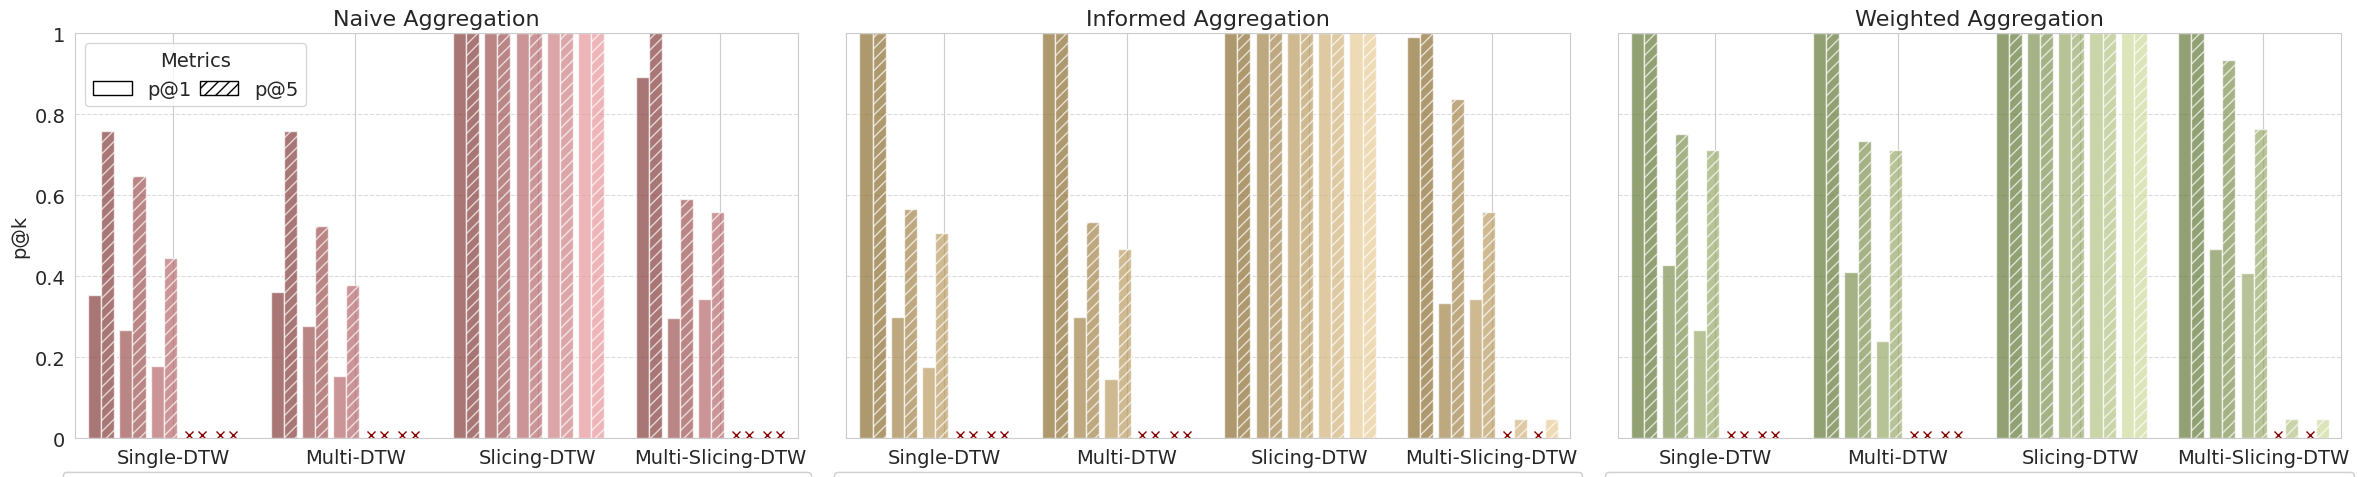

In [131]:
# Define hatches for each metric
hatches = ['', '///', '...']  # No hatch, diagonal lines, dots

# All data info
datasets = ['WESAD', 'CGAN$_{15}$', 'DGAN$_{15}$', 'CGAN$_{10000}$', 'DGAN$_{10000}$']
attacks = ['Single-DTW', 'Multi-DTW', 'Slicing-DTW', 'Multi-Slicing-DTW']
metrics = ['p@1', 'p@5'] # ['p@1', 'p@3', 'p@5']

def plotting(ax, aggregation, values):
    # Define bar width and positions
    bar_width = 0.05
    dataset_spacing = 1.2
    attack_spacing = 0.1
    group_width = len(datasets) * len(metrics) * bar_width * dataset_spacing
    index = np.arange(len(attacks)) * (group_width + attack_spacing)

    # Plot bars for each dataset and metric
    for i, dataset in enumerate(datasets):
        if dataset == "guess":
            color = "darkgray"
        else:
            color = next(colors)
        for j, metric in enumerate(metrics):
            offset = i * len(metrics) * dataset_spacing + j
            pos = index + offset * bar_width
            heights = [values[attack][metric][i][1] for attack in attacks]
            bars = ax.bar(pos, heights, bar_width, label=dataset if j == 0 else "",
                        color=color, alpha=0.7, hatch=hatches[j])
            # mark plots with results that are too low to see
            for k, height in enumerate(heights):
                if height < 0.01:
                    ax.plot(pos[k], 0.007, marker='x', color='darkred', markersize=6)

    # Customize the plot
    ax.set_ylabel('p@k')
    ax.set_title(aggregation + " Aggregation")
    ax.set_xticks(index + group_width / 2)
    ax.set_xticklabels(attacks)

    ax.set_ylim(bottom=0.0, top=1.0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Create a custom legend for p@k values
    if aggregation == "Naive":
        p_at_k_legend_elements = []
        for i, metric in enumerate(metrics):
            p_at_k_legend_elements.append(Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', hatch=hatches[i], label=metric))
        ax.add_artist(ax.legend(handles=p_at_k_legend_elements, title='Metrics', loc='upper left', ncol=len(metrics), columnspacing=0.42))

    # Add the main legend (datasets)
    dataset_legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.27), ncol=len(datasets), columnspacing=0.42, title='Datasets')
    ax.add_artist(dataset_legend)

    # Adjust x-axis limits to reduce spacing on the left and right
    total_width = len(attacks) * (group_width + attack_spacing) - attack_spacing
    margin = group_width / 8
    ax.set_xlim(-margin, total_width)

    # Ensure x-axis labels are centered
    ax.set_xticks(index + group_width / 2)
    ax.set_xticklabels(attacks)

# Create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 5), sharey=True)  # Increased figure height

axes = [ax1, ax2, ax3]
all_bars = []
for ax, key in zip(axes, results_dict):
    agg_color_skips = agg_colors[key]

    markers, colors = init_default_params()
    idxs = [0,1,2,3,4]
    color_skips = [None] * agg_color_skips # skip to correct color
    [next(colors) for skip in color_skips]
    colors = [next(colors) for idx in idxs]
    colors = itertools.cycle([colors[idx] for idx in idxs]) # correct color order

    plotting(ax, key, results_dict[key])

ax2.set_ylabel('')
ax3.set_ylabel('')

# Adjust layout
fig.tight_layout()
#plt.subplots_adjust(wspace=0.01, bottom=0.2)  # reduce subplot spacing and add bottom for legend

plt.savefig(os.path.join("./attacks_eval.pdf"), format="pdf", bbox_inches="tight", pad_inches=1)
plt.show()


## In-Out Threshold

<ipython-input-132-02926f7b4b0f>:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_results = pd.concat([threshold_results, new_row], axis=0)


['[0,0=$[None,None]', '$t_{WESAD}=$[0,0.0]', '$t_{CGAN}=$[0,0.25]', '$t_{DGAN}=$[0,0.32]']


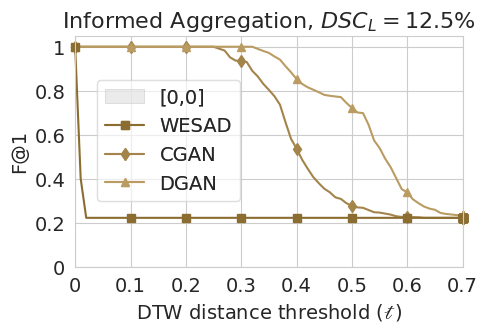

<ipython-input-132-02926f7b4b0f>:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_results = pd.concat([threshold_results, new_row], axis=0)


['[0,0=$[None,None]', '$t_{WESAD}=$[0,0.0]', '$t_{CGAN}=$[0,0.27]', '$t_{DGAN}=$[0,0.34]']


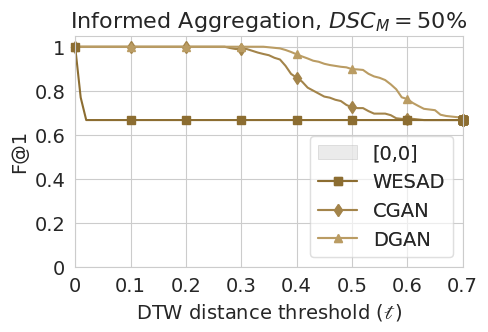

<ipython-input-132-02926f7b4b0f>:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_results = pd.concat([threshold_results, new_row], axis=0)


['[0,$\\infty$=$[0,$\\infty$]', '$t_{WESAD}=$[0,$\\infty$]', '$t_{CGAN}=$[0,$\\infty$]', '$t_{DGAN}=$[0,$\\infty$]']


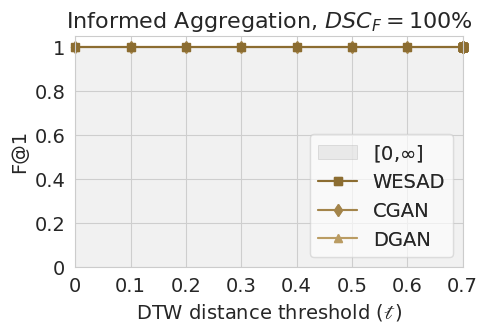

In [132]:
@dataclass
class Dataset:
    file_name: str
    show_name: str
    subject_count: int

def run_evaluation_threshold_attacks(datasets: List[Dataset], overlap: str):
    """
    Evaluation of threshold attacks; Create PDF including f1 results for given datasets and overlap for all thresholds
    :param datasets: List with all datasets that should be considered in evaluation
    :param overlap: Specify overlap (proportion) of subjects included in dataset
    ("small": 0.125, "medium": 0.5 or "high": 1.0)
    """
    f1_results = dict()
    thresholds = list()
    labels = list()
    save_path = os.path.join("./")
    for dataset in datasets:
        try:
            filename = (dataset.file_name + "_" + str(dataset.subject_count) + "_threshold_results_" + str(overlap) +
                        ".json")
            with open(os.path.join(save_path, filename), "r") as outfile:
                results = json.load(outfile)
                results = {float(k): v for k, v in results.items()}
                labels.append(dataset.show_name)

                f1_results.setdefault(dataset.show_name, list())
                for threshold in results:
                    f1_results[dataset.show_name].append(results[threshold]["mean"]["f1"])
                    if threshold not in thresholds:
                        thresholds.append(threshold)

        except FileNotFoundError:
            print("Threshold attack results for " + dataset.show_name + " with " + str(len(dataset.subject_list)) +
                  " subjects and overlap=" + str(overlap) + " are not available!")

    threshold_results = pd.DataFrame(columns=["threshold", "dataset", "f1"])
    for dataset in labels:
        for threshold, f1_score in zip(thresholds, f1_results[dataset]):
            # if threshold == 1:
            #     print(threshold, dataset, f1_score)
            if threshold <= 0.7:  # Ensure threshold condition is applied here
                new_row = pd.DataFrame({
                    "threshold": [threshold],
                    "dataset": [dataset],
                    "f1": [f1_score],
                })
            threshold_results = pd.concat([threshold_results, new_row], axis=0)

    fig, ax = plt.subplots(figsize=(5,3))

    # Highlight the area where F1-score equals 1 for each dataset
    t_opt = {}
    for key, group in threshold_results.groupby("dataset"):
        # Extract x-values where F1-score is 1
        x_values = group[group['f1'] == 1]['threshold']
        if key == "WESAD":
            label = "N/A"
            area = [0.0,0.0]
            if overlap == "high" and SENSOR_AGGREGATION == "Naive":
                label = "[0.1,$\infty$]"
                area = [0.1,1]
            elif overlap == "high" and SENSOR_AGGREGATION == "Informed":
                label = "[0,$\infty$]"
                area = [0.0,1]
            elif overlap != "high" and SENSOR_AGGREGATION == "Informed":
                label = "[0,0]"
                area = [0.0,0.0]

            ax.fill_between(
                    area, # todo x_values
                    0, 1,
                    color='lightgrey', alpha=0.3,
                    # label='$t_{opt}$\n['+str(list(x_values)[0])+","+str(list(x_values)[-1] if overlap!="high" else "$\infty$")+"]", # new line
                    label=label, #todo '['+str(list(x_values)[0])+","+str(list(x_values)[-1] if overlap!="high" else "$\infty$")+"]",
                    edgecolor='darkgrey', linewidth=0.5
            )

        x_values = list(x_values)
        # Plot the mean line
        ax = group.plot('threshold', 'f1', label=key, ax=ax, linestyle=None, color=next(colors), marker=next(markers), markevery=10, clip_on=False)

        t_opt[key] = (x_values[0], x_values[-1])

    # Set the x-axis limit to start from 0
    ax.set_xlim(left=0, right=0.7)
    ax.set_ylim(bottom=0, top=1.05)

    plt.locator_params(axis="x", nbins=8)
    plt.locator_params(axis="y", nbins=8)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    # sort legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,3,0,1]
    bbox_x = 0.55 if SENSOR_AGGREGATION == "Naive" else 0.45
    legend1 = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], framealpha=0.42,
                         loc="upper right" if overlap=="small" else "lower right",
                         bbox_to_anchor=(bbox_x, 0.85) if overlap=="small" else None)

    # plot optimal threshold ranges as legend
    def find_overlap(range1, range2):
        # Unpack the tuples
        start1, end1 = range1
        start2, end2 = range2

        # Calculate the overlap
        overlap_start = max(start1, start2)
        overlap_end = min(end1, end2)

        # Check if there is an actual overlap
        if overlap_start < overlap_end:
            return (overlap_start, overlap_end)
        else:
            return None  # No overlap

    # Start with the first range
    t_opt['$t_{opt}$'] = (0,1)

    # Iterate over the rest of the ranges
    for key in t_opt:
        current_range = t_opt[key]
        t_opt['$t_{opt}$'] = find_overlap(t_opt['$t_{opt}$'], current_range)
        if t_opt['$t_{opt}$'] is None:
            break  # No common overlap

    t_opt['$t_{opt}$'] = t_opt['$t_{opt}$'] if t_opt['$t_{opt}$'] else (None,None)

    t_labels = [
        "$t_{"+labels[idx].replace("$", "") +"}=$[" # not t_opt
        +str(t_opt[labels[idx]][0] if t_opt[labels[idx]][0] != 0 else "0")+","
        +str(t_opt[labels[idx]][1] if overlap!="high" else "$\infty$")+"]"
        if idx != 2 else labels[idx][:-1]+"=$[" # t_opt
        +str(t_opt['$t_{opt}$'][0]) +","
        +str(t_opt['$t_{opt}$'][1] if overlap!="high" else "$\infty$")+"]"
         for idx in order]

    # no extra legend and instead just t_opt
    # legend2 = plt.legend([handles[idx] for idx in order], t_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, columnspacing=0.7)
    # legend2.get_frame().set_linewidth(0.0)

    ax.add_artist(legend1)

    print(t_labels)

    if overlap == "high":
        title = SENSOR_AGGREGATION + " Aggregation" + ", $DSC_{F}=$100%"
    elif overlap == "medium":
        title = SENSOR_AGGREGATION + " Aggregation" + ", $DSC_{M}=$50%"
    elif overlap == "small":
        title = SENSOR_AGGREGATION + " Aggregation" + ", $DSC_{L}=$12.5%"
    plt.title(title)

    plt.ylabel("F@1")
    plt.xlabel("DTW distance threshold ($\mathscr{t}$)")

    # additional legend plot
    # handles, labels = ax.get_legend_handles_labels()
    # legend_fig = plt.figure(figsize=(5, 1))  # Adjust size as needed
    # legend = legend_fig.legend(handles[1:], labels[1:], loc='center', ncol=len(handles))
    # legend_fig.gca().set_axis_off()
    # legend_fig.savefig("./threshold_attacks_" + str(overlap) + "_" + SENSOR_AGGREGATION.lower() + "_legend.pdf", bbox_inches='tight', pad_inches=0.0)
    # plt.close(legend_fig)


    plt.savefig(os.path.join("./threshold_attacks_" + str(overlap) + "_" + SENSOR_AGGREGATION.lower() + ".pdf"), format="pdf",
                bbox_inches="tight")
    plt.show()

# run for all overlaps
datasets = [
    Dataset(file_name="WESAD", show_name="WESAD", subject_count=15),
    Dataset(file_name="WESAD-cGAN", show_name="CGAN", subject_count=120),
    Dataset(file_name="WESAD-dGAN", show_name="DGAN", subject_count=120)
]

overlaps = ["small", "medium", "high"]
for overlap in overlaps:
    markers, colors = init_default_params()
    idxs = [1,2,0]
    markers = itertools.cycle([list(itertools.islice(markers, 4))[idx] for idx in idxs]) # correct marker order
    color_skips = [None] * aggregation_color_skips # skip to correct color
    [next(colors) for skip in color_skips]
    colors = [next(colors) for idx in idxs]
    colors = itertools.cycle([colors[idx] for idx in idxs]) # correct color order

    run_evaluation_threshold_attacks(datasets, overlap)

## Privacy

        attack  noise-multiplier   mean  standard-deviation
25  Single-DTW               0.0  1.000               0.000
26  Single-DTW               0.1  0.887               0.027
27  Single-DTW               0.2  0.842               0.032
28  Single-DTW               0.3  0.809               0.036
29  Single-DTW               0.4  0.762               0.043
30  Single-DTW               0.5  0.705               0.045
31  Single-DTW               0.6  0.598               0.080
32  Single-DTW               0.7  0.583               0.044
33  Single-DTW               0.8  0.557               0.060
34  Single-DTW               0.9  0.534               0.045
35  Single-DTW               1.0  0.561               0.053
36  Single-DTW               2.0  0.406               0.044
37  Single-DTW               3.0  0.409               0.059
38  Single-DTW               4.0  0.353               0.056
39  Single-DTW               5.0  0.317               0.042
40  Single-DTW               6.0  0.249 

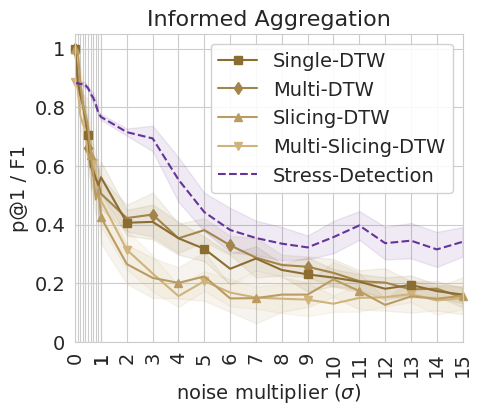

In [133]:
markers, colors = init_default_params()
idxs = [1,3,0,2,4]
markers = itertools.cycle([list(itertools.islice(markers, 4))[idx] for idx in idxs[:-1]]) # correct marker order
color_skips = [None] * aggregation_color_skips # skip to correct color
[next(colors) for skip in color_skips]
colors = [next(colors) for idx in idxs]
colors = itertools.cycle([colors[idx] for idx in idxs]) # correct color order

# privacy plot
def create_attack_dict():
    if SENSOR_AGGREGATION == "Informed-old":
        with open('./wesad_privacy.json') as f:
            privacy_results = pd.read_json(f)
            privacy_results.attack = [x[:-7] if not x.startswith("Stress") else x for x in privacy_results.attack]
    else:
        combined_dict = {}

        file_list = [
            ('5-LOSO_15real_noised.csv', 'Stress-Detection'),
            ('./privacy_results_Single-DTW-Attack.json', 'Single-DTW'),
            ('./privacy_results_Multi-DTW-Attack.json', 'Multi-DTW'),
            ('./privacy_results_Slicing-DTW-Attack.json', 'Slicing-DTW'),
            ('./privacy_results_Multi-Slicing-DTW-Attack.json', 'Multi-Slicing-DTW')
        ]

        privacy_results = pd.DataFrame()
        for path, attack_name in file_list:
            if path.endswith(".csv"):
                df = pd.read_csv(path, usecols=[1,2,3])
                df.columns = ['noise-multiplier', 'mean', 'standard-deviation']
                df = df.astype('float')
                df.insert(0, 'attack', attack_name)
                privacy_results = pd.concat([privacy_results, df], ignore_index=True)
            else:
                df = pd.read_json(path, orient='index', dtype={'index': float}, convert_axes=False)
                df.reset_index(inplace=True)
                df.rename(columns={'index': 'noise-multiplier'}, inplace=True)
                df.drop(columns=[str(i) for i in range(1, 11)], inplace=True)
                df = df.astype('float')
                df.insert(0, 'attack', attack_name)
                privacy_results = pd.concat([privacy_results, df], ignore_index=True)
    return privacy_results

privacy_results = create_attack_dict()

print(privacy_results[privacy_results["attack"]=="Single-DTW"]) # output for exact values in paper

fig, ax = plt.subplots(figsize=(5,4)) # 7,4

for key, group in privacy_results.groupby("attack"):
    linestyle = '--' if key == 'Stress-Detection' else None

    # Plot the mean line
    ax = group.plot('noise-multiplier', 'mean', label=key, ax=ax, linestyle=linestyle,
                    color=next(colors) if not key == 'Stress-Detection' else 'rebeccapurple',
                    marker=next(markers) if linestyle == None else None, markevery=0.2, clip_on=False)

    # Get the color of the line
    color = ax.get_lines()[-1].get_color()

    # Plot the standard deviation as a shaded area
    ax.fill_between(group['noise-multiplier'],
                    group['mean'] - group['standard-deviation'],
                    group['mean'] + group['standard-deviation'],
                    alpha=0.1, color=color)

# Customize x-axis ticks to reflect the varying step sizes
x_ticks = np.concatenate([np.arange(0, 1.1, 0.1), np.arange(1, 16, 1)])
ax.set_xticks(x_ticks)

# Set labels for only some of the ticks
x_labels = [str(int(tick)) if ((tick % 1 == 0 or tick == 2) and tick not in []) else '' for tick in x_ticks]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)

# Set the x-axis limit to start from 0
ax.set_xlim(left=0, right=15)
ax.set_ylim(bottom=0, top=1.05)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

# set legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,1,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right", framealpha=0.9)

title = SENSOR_AGGREGATION + " Aggregation"
plt.title(title)

plt.ylabel("p@1 / F1")
plt.xlabel(r'noise multiplier ($\sigma$)')
plt.savefig("privacy_vs_usability_"+SENSOR_AGGREGATION.lower()+".pdf", format="pdf", bbox_inches="tight")
plt.show()

## Zip Figures

In [134]:
savename = 'eval_figures_'+SENSOR_AGGREGATION.lower()
with zipfile.ZipFile(savename+".zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
  for entry in os.scandir('./'):
      if entry.is_dir():
          continue  # Just in case there are strangely-named directories
      if entry.path.endswith(".pdf"):
          # Add each file to the ZIP archive
          zipf.write(entry, os.path.join(savename, os.path.basename(entry)))